In [1]:
#import paskages
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model

In [2]:
dataset_dir = 'brain-mri/archive'
train_dir = os.path.join(dataset_dir, 'Train')
val_dir = os.path.join(dataset_dir, 'Val') 

In [3]:
import os

# Set dataset directory and train/val paths
dataset_dir = '/kaggle/input/brain-mri/archive'
train_dir = os.path.join(dataset_dir, 'Train')
val_dir = os.path.join(dataset_dir, 'Val')

# Check if directories exist
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    print(f"Error: '{train_dir}' or '{val_dir}' does not exist.")
else:
    # Define classes for Train and Val directories
    train_classes = {cls: os.listdir(os.path.join(train_dir, cls, 'images')) for cls in os.listdir(train_dir)}
    val_classes = {cls: os.listdir(os.path.join(val_dir, cls, 'images')) for cls in os.listdir(val_dir)}

    print('Train Classes:', train_classes.keys())
    print('Val Classes:', val_classes.keys())


Train Classes: dict_keys(['Pituitary', 'No Tumor', 'Meningioma', 'Glioma'])
Val Classes: dict_keys(['Pituitary', 'No Tumor', 'Meningioma', 'Glioma'])


In [4]:
train_classes = {cls: os.listdir(os.path.join(train_dir, cls, 'images')) for cls in os.listdir(train_dir)}
val_classes = {cls: os.listdir(os.path.join(val_dir, cls, 'images')) for cls in os.listdir(val_dir)}

print('Train Classes:', train_classes.keys())
print('Val Classes:', val_classes.keys())


Train Classes: dict_keys(['Pituitary', 'No Tumor', 'Meningioma', 'Glioma'])
Val Classes: dict_keys(['Pituitary', 'No Tumor', 'Meningioma', 'Glioma'])


In [5]:
for set_type, classes in [('Train', train_classes), ('Val', val_classes)]:
    print(f'\n{set_type} Image Counts:')
    for class_name, images in classes.items():
        print(f'{class_name}: {len(images)} images')


Train Image Counts:
Pituitary: 1424 images
No Tumor: 711 images
Meningioma: 1449 images
Glioma: 1153 images

Val Image Counts:
Pituitary: 136 images
No Tumor: 100 images
Meningioma: 140 images
Glioma: 136 images


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,         # Normalizes the pixel values of the images
    rotation_range=20,       #Randomly rotates images within a specified degree range
    width_shift_range=0.1,   #Randomly shifts the image horizontally
    height_shift_range=0.1,  #Randomly shifts the image vertically.
    shear_range=0.1,         #Applies shear transformations
    zoom_range=0.1,          #Randomly zooms into the image.
    horizontal_flip=True     #Randomly flips the image horizontally
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 4737 images belonging to 4 classes.
Found 512 images belonging to 4 classes.


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent training them
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Assuming 4 classes: Glioma, Meningioma, No Tumor, Pituitary
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

]

In [10]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731472241.594304     109 service.cc:145] XLA service 0x7f8b4c00f570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731472241.594368     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731472241.594375     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/149 ━━━━━━━━━━━━━━━━━━━━ 55:44 23s/step - accuracy: 0.2188 - loss: 2.0919 - precision: 0.1333 - recall: 0.0625

I0000 00:00:1731472257.276417     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


149/149 ━━━━━━━━━━━━━━━━━━━━ 110s 593ms/step - accuracy: 0.5630 - loss: 1.0766 - precision: 0.6206 - recall: 0.4547 - val_accuracy: 0.8496 - val_loss: 0.4296 - val_precision: 0.8747 - val_recall: 0.8184 - learning_rate: 1.0000e-04
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 60s 381ms/step - accuracy: 0.7948 - loss: 0.5541 - precision: 0.8269 - recall: 0.7443 - val_accuracy: 0.8633 - val_loss: 0.3783 - val_precision: 0.8755 - val_recall: 0.8379 - learning_rate: 1.0000e-04
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - accuracy: 0.8265 - loss: 0.4564 - precision: 0.8512 - recall: 0.7929 - val_accuracy: 0.8887 - val_loss: 0.3293 - val_precision: 0.8996 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 375ms/step - accuracy: 0.8318 - loss: 0.4329 - precision: 0.8563 - recall: 0.8054 - val_accuracy: 0.8867 - val_loss: 0.2977 - val_precision: 0.9049 - val_recall: 0.8730 - learning_rate: 1.0000e-04
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 37

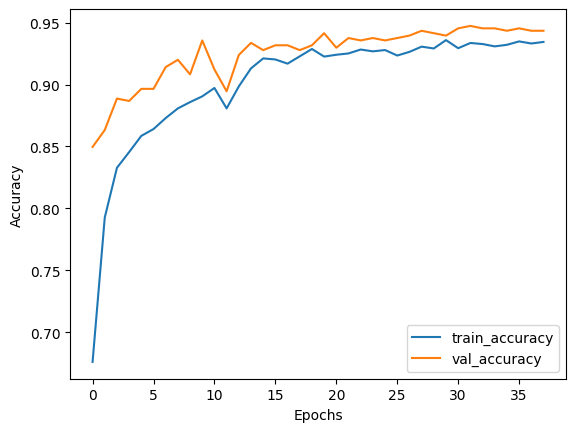

In [11]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 

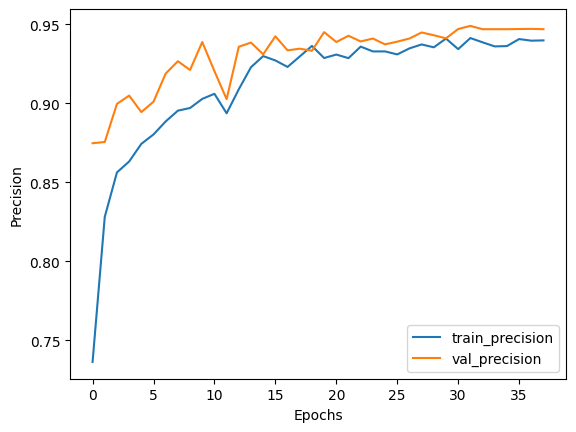

In [12]:
# Plot training and validation precision
plt.plot(history.history['precision'], label='train_precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


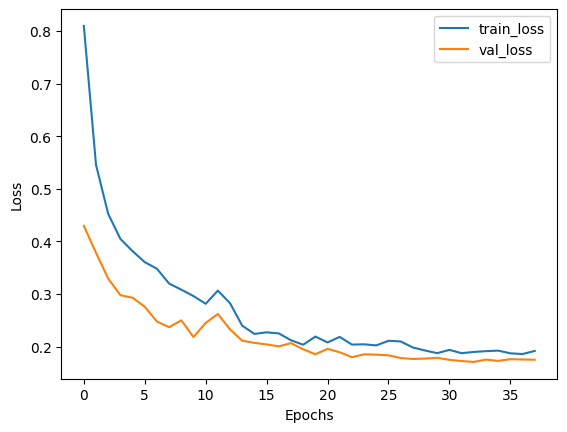

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

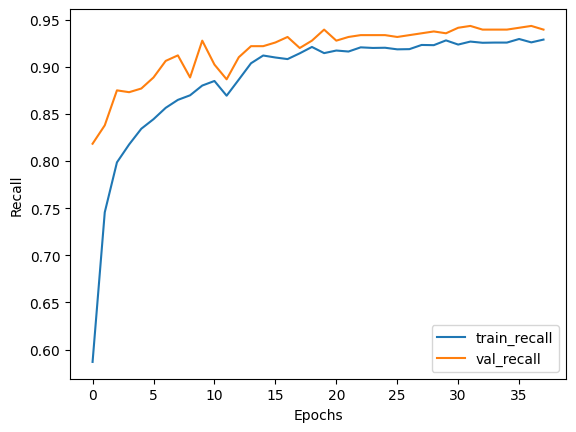

In [14]:
# Plot training and validation recall
plt.plot(history.history['recall'], label='train_recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [15]:
# Save the entire model after training
model.save('vgg16_cancer_detection_model.h5')  # Saves in HDF5 format

In [17]:
# Extract the number of epochs from the history
epochs = len(history.history['accuracy'])

# Print metrics for each epoch
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training - Accuracy: {history.history['accuracy'][epoch]:.4f}, "
          f"Precision: {history.history['precision'][epoch]:.4f}, "
          f"Loss: {history.history['loss'][epoch]:.4f}, "
          f"Recall: {history.history['recall'][epoch]:.4f}")
    
    print(f"Validation - Accuracy: {history.history['val_accuracy'][epoch]:.4f}, "
          f"Precision: {history.history['val_precision'][epoch]:.4f}, "
          f"Loss: {history.history['val_loss'][epoch]:.4f}, "
          f"Recall: {history.history['val_recall'][epoch]:.4f}")
    
    print("-" * 50)


Epoch 1/38
Training - Accuracy: 0.6762, Precision: 0.7364, Loss: 0.8095, Recall: 0.5869
Validation - Accuracy: 0.8496, Precision: 0.8747, Loss: 0.4296, Recall: 0.8184
--------------------------------------------------
Epoch 2/38
Training - Accuracy: 0.7927, Precision: 0.8281, Loss: 0.5455, Recall: 0.7456
Validation - Accuracy: 0.8633, Precision: 0.8755, Loss: 0.3783, Recall: 0.8379
--------------------------------------------------
Epoch 3/38
Training - Accuracy: 0.8328, Precision: 0.8563, Loss: 0.4523, Recall: 0.7986
Validation - Accuracy: 0.8887, Precision: 0.8996, Loss: 0.3293, Recall: 0.8750
--------------------------------------------------
Epoch 4/38
Training - Accuracy: 0.8455, Precision: 0.8632, Loss: 0.4047, Recall: 0.8176
Validation - Accuracy: 0.8867, Precision: 0.9049, Loss: 0.2977, Recall: 0.8730
--------------------------------------------------
Epoch 5/38
Training - Accuracy: 0.8586, Precision: 0.8743, Loss: 0.3814, Recall: 0.8343
Validation - Accuracy: 0.8965, Precision

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/working/vgg16_cancer_detection_model.h5')

# Define the class labels based on your training dataset
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Function to predict the class of the image
def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    return class_labels[predicted_class[0]], predictions[0][predicted_class[0]]

# Example usage
image_path = '/kaggle/input/brain-mri/archive/Val/Meningioma/images/Tr-me_0012.jpg'  # Replace with your image path
predicted_label, confidence = predict_image(image_path)



print(f'Predicted Class: {predicted_label}, Confidence: {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Predicted Class: Meningioma, Confidence: 0.97


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


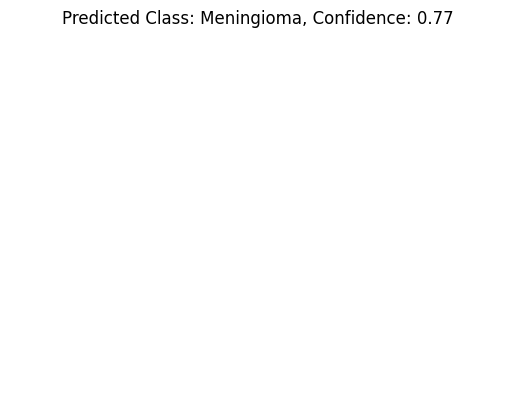

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/vgg16_cancer_detection_model.h5')

# Define the class labels based on your training dataset
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img, img_array  # Return both the loaded image and the preprocessed array

# Function to predict the class of the image
def predict_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    return img, class_labels[predicted_class[0]], predictions[0][predicted_class[0]]

# Example usage
image_path = '/kaggle/input/brain-mri/archive/Val/Meningioma/images/Tr-meTr_0000.jpg'  # Replace with your image path
img, predicted_label, confidence = predict_image(image_path)

# Display the image with prediction and confidence score plt.imshow(img)
plt.title(f'Predicted Class: {predicted_label}, Confidence: {confidence:.2f}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


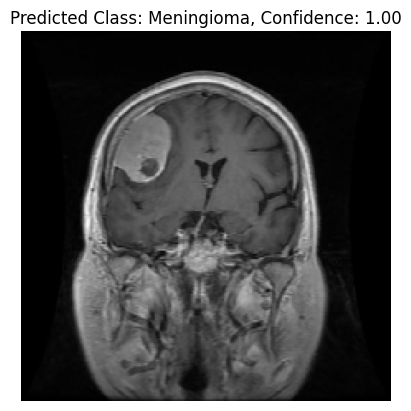

Predicted Class: Meningioma, Confidence: 1.00


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/vgg16_cancer_detection_model.h5')

# Define the class labels based on your training dataset
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img, img_array  # Return both the PIL image and the preprocessed array

# Function to predict the class of the image and display it
def predict_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    confidence = predictions[0][predicted_class[0]]
    
    # Display the image along with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {class_labels[predicted_class[0]]}, Confidence: {confidence:.2f}')
    plt.show()

    return class_labels[predicted_class[0]], confidence

# Example usage
image_path = '/kaggle/input/brain-mri/archive/Val/Meningioma/images/Tr-me_0139.jpg'  # Replace with your image path
predicted_label, confidence = predict_image(image_path)

print(f'Predicted Class: {predicted_label}, Confidence: {confidence:.2f}')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/input/vgg16brain/vgg16_cancer_detection_model.h5')

# Define the class labels based on your training dataset
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Load validation dataset (assuming you have the ImageDataGenerator and validation directory setup)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths for validation data
validation_dir = '/kaggle/input/brain-mri/archive/Val'  # Set your validation directory path
image_size = (224, 224)
batch_size = 32

# Set up ImageDataGenerator for validation dataset
datagen = ImageDataGenerator(rescale=1./255)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set to get accuracy, precision, loss, and recall
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img, img_array  # Return both the PIL image and the preprocessed array

# Function to predict the class of the image and display it
def predict_image(img_path):
    img, img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    confidence = predictions[0][predicted_class[0]]
    
    # Display the image along with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {class_labels[predicted_class[0]]}, Confidence: {confidence:.2f}')
    plt.show()

    # Print evaluation metrics
    print("Model Evaluation Metrics on Validation Set:")
    print(f"Accuracy: {val_accuracy:.2f}")
    print(f"Precision: {val_precision:.2f}")
    print(f"Loss: {val_loss:.2f}")
    print(f"Recall: {val_recall:.2f}")

    return class_labels[predicted_class[0]], confidence

# Example usage
image_path = '/kaggle/input/meningioma-val/Val_meningioma_1.jpeg'  # Replace with your image path
predicted_label, confidence = predict_image(image_path)

print(f'Predicted Class: {predicted_label}, Confidence: {confidence:.2f}')
